In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
# Параметры распределений
mean_0 = [3., -1]
covariance_0 = [[1.5, 0], 
                [0, 1.]]
mean_1 = [-2., 2]
covariance_1 = [[3.5, 0], 
                [0, 2.5]]

In [3]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [4]:
d0 = torch.distributions.MultivariateNormal(torch.tensor(mean_0), torch.tensor(covariance_0))
d1 = torch.distributions.MultivariateNormal(torch.tensor(mean_1), torch.tensor(covariance_1))

In [5]:
# Проверяем
d1.sample((5,))

tensor([[-1.7747, -0.4520],
        [-1.4538,  3.0820],
        [-6.6007,  2.9766],
        [-1.8299,  3.5346],
        [ 2.3757,  1.7506]])

In [6]:
# Создаём сетку
x_scale = np.linspace(-20, 20, 1000)
y_scale = np.linspace(-20, 20, 1000)
X,Y = np.meshgrid(x_scale,y_scale)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X; pos[:, :, 1] = Y

In [7]:
# Получаем плотности распределений
d0_pdf = stats.multivariate_normal.pdf(pos, mean_0, covariance_0)
d1_pdf = stats.multivariate_normal.pdf(pos, mean_1, covariance_1)
ratio = d1_pdf / (d1_pdf + d0_pdf)

<function matplotlib.pyplot.show(*args, **kw)>

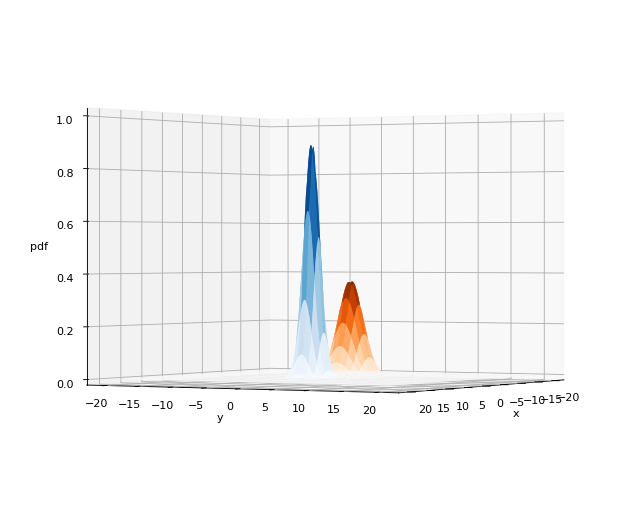

In [8]:
# Рисуем плотности распределения
fig = plt.figure(num=None, figsize=(10, 8), dpi=80)
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('pdf')
ax.set_zlim(0, 1.01)
ax.view_init(0, 30)

ax.plot_surface(X, Y, d1_pdf*7, cmap=cm.Oranges)
ax.plot_surface(X, Y, d0_pdf*7, cmap=cm.Blues)

plt.show

In [9]:
# Задаем параметры сети
net = nn.Sequential(nn.Linear(2, 16), nn.ReLU(), nn.Linear(16, 1))
print([p.data[0] for p in net.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(net.parameters()))

[tensor([ 0.5169,  0.4063]), tensor(-0.1314), tensor([ 0.0768,  0.1331,  0.1902, -0.1733, -0.1659,  0.1851,  0.2385,
         0.1304, -0.1502, -0.1604,  0.0373, -0.1612,  0.1985,  0.1809,
        -0.1863, -0.0014]), tensor(1.00000e-02 *
       -4.1947)]


In [10]:
# Обучаем н.с.
log_freq = 500
for i in range(25000):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(net(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    layer_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = F.sigmoid(net(x))
    loss = F.binary_cross_entropy(out, y)
    loss.backward()
    layer_opt.step()

Ошибка после 0 итераций: 0.521532
Ошибка после 1 итераций: 0.293713
Ошибка после 2 итераций: 0.213194
Ошибка после 3 итераций: 0.172495
Ошибка после 4 итераций: 0.149644
Ошибка после 5 итераций: 0.133777
Ошибка после 6 итераций: 0.122884
Ошибка после 7 итераций: 0.113735
Ошибка после 8 итераций: 0.107210
Ошибка после 9 итераций: 0.101751
Ошибка после 10 итераций: 0.097388
Ошибка после 11 итераций: 0.094883
Ошибка после 12 итераций: 0.092039
Ошибка после 13 итераций: 0.089830
Ошибка после 14 итераций: 0.087592
Ошибка после 15 итераций: 0.084795
Ошибка после 16 итераций: 0.083054
Ошибка после 17 итераций: 0.082570
Ошибка после 18 итераций: 0.079901
Ошибка после 19 итераций: 0.078088
Ошибка после 20 итераций: 0.077150
Ошибка после 21 итераций: 0.076018
Ошибка после 22 итераций: 0.075474
Ошибка после 23 итераций: 0.074496
Ошибка после 24 итераций: 0.073977
Ошибка после 25 итераций: 0.072705
Ошибка после 26 итераций: 0.071640
Ошибка после 27 итераций: 0.071925
Ошибка после 28 итераций: 0.07

<function matplotlib.pyplot.show(*args, **kw)>

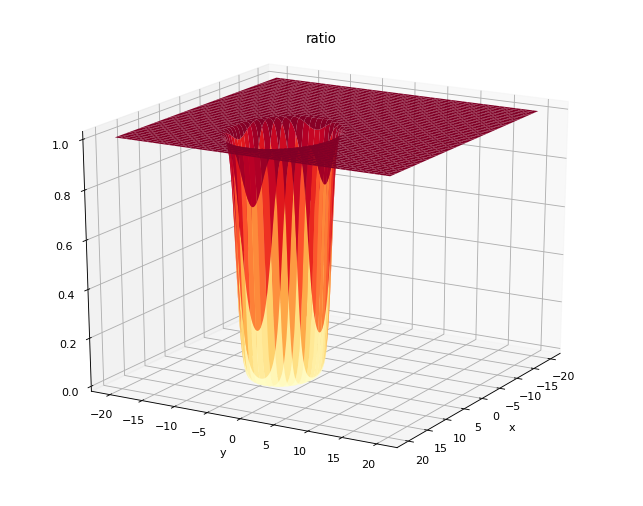

In [11]:
# Рисуем график отношения плотности целевого раcпределения к суммарной плотности двух распределений
fig = plt.figure(num=None, figsize=(10, 8), dpi=80)
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim(0, 1.01)
ax.view_init(20, 30)
plt.title('ratio')

ax.plot_surface(X, Y, ratio, cmap=cm.YlOrRd)

plt.show

In [12]:
x_tensor = torch.tensor(pos, dtype=torch.float)
with torch.no_grad():
    dist = F.sigmoid(net(x_tensor)).numpy()
dist.shape

(1000, 1000, 1)

<function matplotlib.pyplot.show(*args, **kw)>

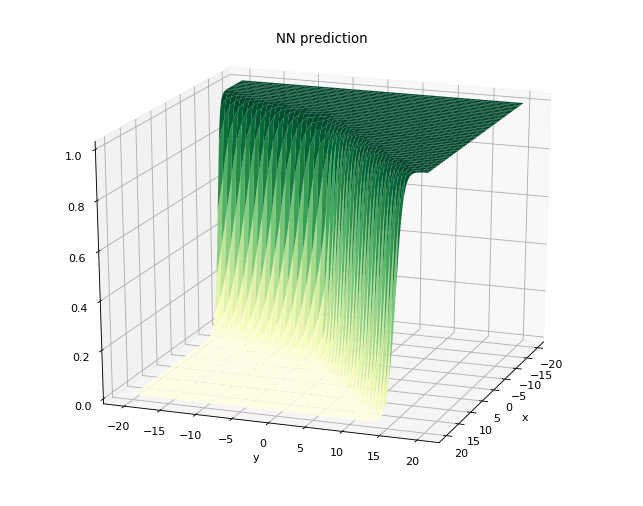

In [13]:
# Рисуем график предсказания вероятности принадлежности точки к целевому распределению
fig = plt.figure(num=None, figsize=(10, 8), dpi=80)
ax = fig.gca(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlim(0, 1.01)
ax.view_init(20, 20)
plt.title('NN prediction')

ax.plot_surface(X, Y, dist[:,:,-1], cmap=cm.YlGn)
#ax.plot_wireframe(X, Y, dist[:,:,-1], rstride=20, cstride=20)

plt.show